In [9]:
import torch
import requests
import os
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [10]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, noise, transform=None, target_transform=None, drop=None, target=None):
        self.dataframe = dataframe
        if drop != None:
            self.X = dataframe.drop(drop, axis=1).values
        else:
            self.X = dataframe.values
        
        self.y = dataframe[target].values
        self.transform = transform
        self.target_transform = target_transform
        self.noise = noise

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        item, label = self.X[idx], self.y[idx]
        return item, label

    def get_noise(self):
        return self.noise

In [11]:
Noise_0_dataframe = pd.read_csv("../Data/Assignment1/data_0_noise")
Noise_Low_dataframe = pd.read_csv("../Data/Assignment1/data_Low_noise")
Noise_High_dataframe = pd.read_csv("../Data/Assignment1/data_High_noise")

In [4]:
class_index = list(Noise_0_dataframe["era"].unique())
class_index_noise = list(Noise_Low_dataframe["era"].unique())
class_index_t10v_noise = list(Noise_Low_dataframe["target_10_val"].unique())

def encode(value, class_index = class_index):
    return class_index.index(value)

def encode_noise(value, class_index = class_index_noise):
    return class_index.index(value)

def encode_noise_t10v(value, class_index = class_index_t10v_noise):
    return class_index.index(value)


Noise_0_dataframe["era"] = Noise_0_dataframe["era"].apply(encode)
Noise_Low_dataframe["era"] = Noise_Low_dataframe["era"].apply(encode_noise)
Noise_High_dataframe["era"] = Noise_High_dataframe["era"].apply(encode_noise)
Noise_Low_dataframe["target_10_val"] = Noise_Low_dataframe["target_10_val"].apply(encode_noise_t10v)
Noise_High_dataframe["target_10_val"] = Noise_High_dataframe["target_10_val"].apply(encode_noise_t10v)

In [34]:
#Setting up datasets
Noise_0_dataset_era = CustomDataset(Noise_0_dataframe, "0",drop = ["row_num","day","era","target_10_val","target_5_val"], target = "era")
Noise_Low_dataset_era = CustomDataset(Noise_Low_dataframe, "Low", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "era")
Noise_High_dataset_era = CustomDataset(Noise_High_dataframe, "High", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "era")
Noise_Low_dataset_t10v = CustomDataset(Noise_Low_dataframe, "Low", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "target_10_val")
Noise_High_dataset_t10v = CustomDataset(Noise_High_dataframe, "High", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "target_10_val")
Noise_0_train_era, Noise_0_test_era = random_split(Noise_0_dataset_era, [int(len(Noise_0_dataset_era)*0.8), int(len(Noise_0_dataset_era)*0.2)])
Noise_Low_train_era, Noise_Low_test_era = random_split(Noise_Low_dataset_era, [int(len(Noise_Low_dataset_era)*0.8), int(len(Noise_Low_dataset_era)*0.2)])
Noise_High_train_era, Noise_High_test_era = random_split(Noise_High_dataset_era, [int(len(Noise_High_dataset_era)*0.8), int(len(Noise_High_dataset_era)*0.2)])
Noise_Low_train_t10v, Noise_Low_test_t10v = random_split(Noise_Low_dataset_t10v, [int(len(Noise_Low_dataset_t10v)*0.8), int(len(Noise_Low_dataset_t10v)*0.2)])
Noise_High_train_t10v, Noise_High_test_t10v = random_split(Noise_High_dataset_t10v, [int(len(Noise_High_dataset_t10v)*0.8), int(len(Noise_High_dataset_t10v)*0.2)])

In [32]:
#Setting up dataloaders
Noise_0_era_train_loader = DataLoader(Noise_0_train_era, batch_size=512, shuffle=True)
Noise_0_era_test_loader = DataLoader(Noise_0_test_era, batch_size=512, shuffle=True)
########################################################################################
Noise_Low_era_train_loader = DataLoader(Noise_Low_train_era, batch_size=512, shuffle=True)
Noise_Low_era_test_loader = DataLoader(Noise_Low_test_era, batch_size=512, shuffle=True)
########################################################################################
Noise_High_era_train_loader = DataLoader(Noise_High_train_era, batch_size=512, shuffle=True)
Noise_High_era_test_loader = DataLoader(Noise_High_test_era, batch_size=512, shuffle=True)
########################################################################################
Noise_Low_t10v_train_loader = DataLoader(Noise_Low_train_t10v, batch_size=512, shuffle=True)
Noise_Low_t10v_test_loader = DataLoader(Noise_Low_test_t10v, batch_size=512, shuffle=True)
########################################################################################
Noise_High_t10v_train_loader = DataLoader(Noise_High_train_t10v, batch_size=512, shuffle=True)
Noise_High_t10v_test_loader = DataLoader(Noise_High_test_t10v, batch_size=512, shuffle=True)
########################################################################################


In [163]:
class EncoderClassifier(torch.nn.Module):
    def __init__(self,representation,latent_dim,linear,subset_size,overlap,activation = torch.nn.ReLU()):
        super().__init__()
        self.encoder = representation
        linear_layers = []
        for i in range(len(linear)-1):
            if i == len(linear)-2:
                linear_layers.append(torch.nn.Linear(linear[i],linear[i+1]))
            else:
                linear_layers.append(torch.nn.Linear(linear[i],linear[i+1]))
                linear_layers.append(activation)
        
        self.linear = torch.nn.Sequential(*linear_layers)
        self.subset_size = subset_size
        self.overlap = overlap
        self.softmax = torch.nn.LogSoftmax(dim = 1)
    
    def forward(self,subset):
        subset = self.encoder(subset)
        subset = self.linear(subset)
        preds = self.softmax(subset)
        return preds
    

In [254]:
class SubsetAutoencoder (torch.nn.Module):
    def __init__(self, encoder_sizes,decoder_sizes,activation = torch.nn.ReLU()):
        super().__init__()
        linear_encoder = [torch.nn.Linear(encoder_sizes[i],encoder_sizes[i+1]) for i in range(len(encoder_sizes)-1)]
        linear_decoder = [torch.nn.Linear(decoder_sizes[i],decoder_sizes[i+1]) for i in range(len(decoder_sizes)-1)]
        self.encoder = []
        
        for i in range(len(encoder_sizes)-1):
            if i == len(encoder_sizes)-2:
                self.encoder.append(torch.nn.Linear(encoder_sizes[i],encoder_sizes[i+1]))
                # self.encoder.append(activation)
            else:
                self.encoder.append(torch.nn.Linear(encoder_sizes[i],encoder_sizes[i+1]))
                self.encoder.append(activation)
            
        self.encoder = torch.nn.Sequential(*self.encoder)
       
        self.decoder = []
        for i in range(len(decoder_sizes)-1):
            if i == len(decoder_sizes)-2:
                self.decoder.append(torch.nn.Linear(decoder_sizes[i],decoder_sizes[i+1]))
            else:
                self.decoder.append(torch.nn.Linear(decoder_sizes[i],decoder_sizes[i+1]))
                self.decoder.append(activation)
            
        self.decoder = torch.nn.Sequential(*self.decoder)
        
    def forward(self,X):
        X = self.encoder(X)
        X = self.decoder(X)
        return X
    
    def get_encoder(self):
        return self.encoder
    
    def get_decoder(self):
        return self.decoder

In [165]:
def get_subsets(current_batch,subset_size,overlap):
        subsets = []
        num_columns = current_batch.shape[1]
        for i in range(0, num_columns-subset_size,subset_size-overlap):
            subsets.append(current_batch[:,i:i+subset_size])
        return subsets

In [292]:
def train_classifier(model, criterion, optimizer, epochs, trainloader, testloader, lr=0.001, verbose=True, subset_size=10, overlap=2):
    optimizer = optimizer(model.parameters(), lr=lr)
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []

    for epoch in range(epochs):
        running_train_loss = 0
        total_train = 0
        correct_train = 0

        # Training
        model.train()
        for data, target in tqdm(trainloader, desc="Training Epoch " + str(epoch)):
            data, target = data.to(device).float(), target.to(device).long()
            subsets = get_subsets(data, subset_size, overlap)
            subset_loss = 0
            output = 0
            for subset in subsets:
                optimizer.zero_grad()
                output += model(subset)
                loss = criterion(output, target)
                loss.backward()
                subset_loss += loss
                optimizer.step()
                
            output = output/len(subsets)
            subset_loss /= len(subsets)
            
            running_train_loss += subset_loss.item()/len(subsets)
            _, predicted = torch.max(output, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
            running_train_loss += loss.item()

        accuracy = correct_train / total_train
        train_accuracy.append(accuracy)
        running_train_loss /= len(trainloader)
        train_loss.append(running_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0
        total_val = 0
        correct_val = 0
        with torch.no_grad():
            for data, target in tqdm(testloader, desc="Validation Epoch " + str(epoch)):
                data, target = data.to(
                    device).float(), target.to(device).long()
                subsets = get_subsets(data, subset_size, overlap)
                subset_loss = 0
                output = 0
                for subset in subsets:
                    output += model(subset)
                    loss = criterion(output, target)
                    subset_loss += loss
                    
                output = output/len(subsets)
                running_val_loss += subset_loss.item()/len(subsets)

                _, predicted = torch.max(output, 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()

        running_val_loss /= len(testloader)
        val_loss.append(running_val_loss)
        accuracy_val = correct_val / total_val
        val_accuracy.append(accuracy_val)

        if verbose:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {accuracy:.4f}, Validation Loss: {val_loss[-1]:.4f}, Validation Accuracy: {accuracy_val:.4f}")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [295]:
def train_ae(model, criterion, optimizer, epochs, trainloader, testloader, subset_size=10, overlap=4, lr=0.01, verbose=True):
    optimizer = optimizer(model.parameters(), lr=lr)
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        # Training
        model.train()
        current_train_loss = 0
        for data, _ in tqdm(trainloader, desc="Training Epoch " + str(epoch)):
            data = data.to(device).float()
            subsets = get_subsets(data, subset_size, overlap)
            optimizer.zero_grad()
            recons = []
            subset_loss = 0
            for subset in subsets:
                output = model(subset)
                recons.append(output)
                subset_loss += criterion(subset, output)
            subset_loss = subset_loss.mean()
            subset_loss.backward()
            optimizer.step()
            current_train_loss += subset_loss.item() * data.size(0)
        train_loss.append(current_train_loss / len(trainloader.dataset))
        
        # Validation
        model.eval()
        current_val_loss = 0
        with torch.no_grad():
            for data, _ in tqdm(testloader, desc="Validation Epoch " + str(epoch)):
                data = data.to(device).float()
                subsets = get_subsets(data, subset_size, overlap)
                recons = []
                subset_loss = 0
                for subset in subsets:
                    output = model(subset)
                    recons.append(output)
                    subset_loss += criterion(subset, output)
                subset_loss = subset_loss.mean()
                current_val_loss += subset_loss.item() * data.size(0)
            val_loss.append(current_val_loss / len(testloader.dataset))
        
        if verbose:
            print(f"Epoch [{epoch}/{epochs}], Train Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1]}")
        
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
model = SubsetAutoencoder(encoder_sizes=[18,32,12],decoder_sizes=[12,32,18])
model.to(device)

In [299]:
torch.save(model,"../Models/encoder_decoder_models_0.001")

Validation Epoch 0: 100%|██████████| 122/122 [00:00<00:00, 183.67it/s]


Epoch [0/20], Train Loss: 0.018570281753841882, Validation Loss: 0.00478534378302403


Validation Epoch 1: 100%|██████████| 122/122 [00:00<00:00, 201.09it/s]


Epoch [1/20], Train Loss: 0.003721622957680852, Validation Loss: 0.0023116046044593438


Validation Epoch 2: 100%|██████████| 122/122 [00:00<00:00, 170.34it/s]


Epoch [2/20], Train Loss: 0.001928968060021408, Validation Loss: 0.0017865509829985407


Validation Epoch 3: 100%|██████████| 122/122 [00:00<00:00, 197.90it/s]


Epoch [3/20], Train Loss: 0.0018224959720212679, Validation Loss: 0.001715223166661767


Validation Epoch 4: 100%|██████████| 122/122 [00:00<00:00, 205.05it/s]


Epoch [4/20], Train Loss: 0.0017931497354920095, Validation Loss: 0.001740860963622347


Validation Epoch 5: 100%|██████████| 122/122 [00:00<00:00, 198.04it/s]


Epoch [5/20], Train Loss: 0.0017808907040848564, Validation Loss: 0.0016259813865121357


Validation Epoch 6: 100%|██████████| 122/122 [00:00<00:00, 194.76it/s]


Epoch [6/20], Train Loss: 0.0016405493295632112, Validation Loss: 0.0015794461713626218


Validation Epoch 7: 100%|██████████| 122/122 [00:00<00:00, 182.65it/s]


Epoch [7/20], Train Loss: 0.0016300455036644752, Validation Loss: 0.0015413138614251063


Validation Epoch 8: 100%|██████████| 122/122 [00:00<00:00, 192.42it/s]


Epoch [8/20], Train Loss: 0.0016116501728836924, Validation Loss: 0.0015653821788967038


Validation Epoch 9: 100%|██████████| 122/122 [00:00<00:00, 202.71it/s]


Epoch [9/20], Train Loss: 0.0016140975313595472, Validation Loss: 0.0015319242967197146


Validation Epoch 10: 100%|██████████| 122/122 [00:00<00:00, 196.22it/s]


Epoch [10/20], Train Loss: 0.001615139919046599, Validation Loss: 0.001665253875633845


Validation Epoch 11: 100%|██████████| 122/122 [00:00<00:00, 195.92it/s]


Epoch [11/20], Train Loss: 0.0016039173954572434, Validation Loss: 0.0015114504349632905


Validation Epoch 12: 100%|██████████| 122/122 [00:00<00:00, 208.95it/s]


Epoch [12/20], Train Loss: 0.0016063912599705733, Validation Loss: 0.0023326323241090927


Validation Epoch 13: 100%|██████████| 122/122 [00:00<00:00, 200.51it/s]


Epoch [13/20], Train Loss: 0.001553776766746663, Validation Loss: 0.0015192958442733074


Validation Epoch 14: 100%|██████████| 122/122 [00:00<00:00, 172.34it/s]


Epoch [14/20], Train Loss: 0.0015427377831954987, Validation Loss: 0.00202137043651862


Validation Epoch 15: 100%|██████████| 122/122 [00:01<00:00, 86.86it/s]


Epoch [15/20], Train Loss: 0.001532564033061648, Validation Loss: 0.0015352605506538963


Validation Epoch 16: 100%|██████████| 122/122 [00:01<00:00, 65.41it/s]


Epoch [16/20], Train Loss: 0.0015484996179405313, Validation Loss: 0.001709885695614876


Validation Epoch 17: 100%|██████████| 122/122 [00:02<00:00, 41.56it/s]


Epoch [17/20], Train Loss: 0.0015197458596995625, Validation Loss: 0.001466314690426374


Validation Epoch 18: 100%|██████████| 122/122 [00:02<00:00, 43.67it/s]


Epoch [18/20], Train Loss: 0.0015279797706991816, Validation Loss: 0.001526371915705311


Validation Epoch 19: 100%|██████████| 122/122 [00:03<00:00, 40.23it/s]


Epoch [19/20], Train Loss: 0.0015258699353450002, Validation Loss: 0.001536033306724559


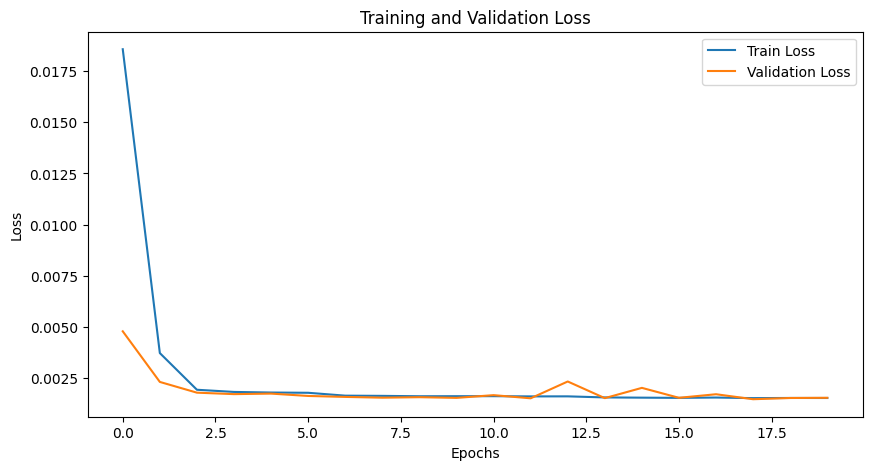

([0.018570281753841882,
  0.003721622957680852,
  0.001928968060021408,
  0.0018224959720212679,
  0.0017931497354920095,
  0.0017808907040848564,
  0.0016405493295632112,
  0.0016300455036644752,
  0.0016116501728836924,
  0.0016140975313595472,
  0.001615139919046599,
  0.0016039173954572434,
  0.0016063912599705733,
  0.001553776766746663,
  0.0015427377831954987,
  0.001532564033061648,
  0.0015484996179405313,
  0.0015197458596995625,
  0.0015279797706991816,
  0.0015258699353450002],
 [0.00478534378302403,
  0.0023116046044593438,
  0.0017865509829985407,
  0.001715223166661767,
  0.001740860963622347,
  0.0016259813865121357,
  0.0015794461713626218,
  0.0015413138614251063,
  0.0015653821788967038,
  0.0015319242967197146,
  0.001665253875633845,
  0.0015114504349632905,
  0.0023326323241090927,
  0.0015192958442733074,
  0.00202137043651862,
  0.0015352605506538963,
  0.001709885695614876,
  0.001466314690426374,
  0.001526371915705311,
  0.001536033306724559])

In [288]:
optimizer = torch.optim.Adam
criterion = torch.nn.MSELoss()
train_ae(model,criterion,optimizer,20,Noise_Low_era_train_loader,Noise_Low_era_test_loader,subset_size = 18,overlap =6, lr=0.01)

In [289]:
for param in model.parameters():
    param.requires_grad = False

In [290]:
classifier = EncoderClassifier(model,8,[18,36,14,12],subset_size=18,overlap=6)
classifier = classifier.to(device)
print(classifier)

EncoderClassifier(
  (encoder): SubsetAutoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=18, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=12, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=12, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=18, bias=True)
    )
  )
  (linear): Sequential(
    (0): Linear(in_features=18, out_features=36, bias=True)
    (1): ReLU()
    (2): Linear(in_features=36, out_features=14, bias=True)
    (3): ReLU()
    (4): Linear(in_features=14, out_features=12, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)


Validation Epoch 0: 100%|██████████| 122/122 [00:00<00:00, 166.72it/s]


Epoch [1/20], Train Loss: 2.4216, Train Accuracy: 0.5463, Validation Loss: 0.9427, Validation Accuracy: 0.6378


Validation Epoch 1: 100%|██████████| 122/122 [00:00<00:00, 147.54it/s]


Epoch [2/20], Train Loss: 1.7882, Train Accuracy: 0.6582, Validation Loss: 0.8649, Validation Accuracy: 0.6727


Validation Epoch 2: 100%|██████████| 122/122 [00:00<00:00, 173.60it/s]


Epoch [3/20], Train Loss: 1.6900, Train Accuracy: 0.6756, Validation Loss: 0.8262, Validation Accuracy: 0.6797


Validation Epoch 3: 100%|██████████| 122/122 [00:00<00:00, 174.30it/s]


Epoch [4/20], Train Loss: 1.6399, Train Accuracy: 0.6820, Validation Loss: 0.8186, Validation Accuracy: 0.6804


Validation Epoch 4: 100%|██████████| 122/122 [00:00<00:00, 178.66it/s]


Epoch [5/20], Train Loss: 1.6126, Train Accuracy: 0.6871, Validation Loss: 0.8101, Validation Accuracy: 0.6849


Validation Epoch 5: 100%|██████████| 122/122 [00:00<00:00, 183.17it/s]


Epoch [6/20], Train Loss: 1.5961, Train Accuracy: 0.6890, Validation Loss: 0.7978, Validation Accuracy: 0.6844


Validation Epoch 6: 100%|██████████| 122/122 [00:00<00:00, 171.87it/s]


Epoch [7/20], Train Loss: 1.5813, Train Accuracy: 0.6908, Validation Loss: 0.8283, Validation Accuracy: 0.6784


Validation Epoch 7: 100%|██████████| 122/122 [00:00<00:00, 174.82it/s]


Epoch [8/20], Train Loss: 1.5633, Train Accuracy: 0.6941, Validation Loss: 0.7856, Validation Accuracy: 0.6936


Validation Epoch 8: 100%|██████████| 122/122 [00:00<00:00, 173.22it/s]


Epoch [9/20], Train Loss: 1.5502, Train Accuracy: 0.6971, Validation Loss: 0.7879, Validation Accuracy: 0.6906


Validation Epoch 9: 100%|██████████| 122/122 [00:00<00:00, 141.59it/s]


Epoch [10/20], Train Loss: 1.5469, Train Accuracy: 0.6972, Validation Loss: 0.7848, Validation Accuracy: 0.6928


Validation Epoch 10: 100%|██████████| 122/122 [00:00<00:00, 177.89it/s]


Epoch [11/20], Train Loss: 1.5389, Train Accuracy: 0.6989, Validation Loss: 0.7745, Validation Accuracy: 0.6932


Validation Epoch 11: 100%|██████████| 122/122 [00:00<00:00, 161.87it/s]


Epoch [12/20], Train Loss: 1.5300, Train Accuracy: 0.6996, Validation Loss: 0.7702, Validation Accuracy: 0.6961


Validation Epoch 12: 100%|██████████| 122/122 [00:00<00:00, 176.84it/s]


Epoch [13/20], Train Loss: 1.5212, Train Accuracy: 0.7015, Validation Loss: 0.7673, Validation Accuracy: 0.7014


Validation Epoch 13: 100%|██████████| 122/122 [00:00<00:00, 156.57it/s]


Epoch [14/20], Train Loss: 1.5263, Train Accuracy: 0.7006, Validation Loss: 0.7703, Validation Accuracy: 0.6896


Validation Epoch 14: 100%|██████████| 122/122 [00:00<00:00, 185.95it/s]


Epoch [15/20], Train Loss: 1.5157, Train Accuracy: 0.7023, Validation Loss: 0.7802, Validation Accuracy: 0.6933


Validation Epoch 15: 100%|██████████| 122/122 [00:00<00:00, 167.79it/s]


Epoch [16/20], Train Loss: 1.5122, Train Accuracy: 0.7032, Validation Loss: 0.7621, Validation Accuracy: 0.6976


Validation Epoch 16: 100%|██████████| 122/122 [00:00<00:00, 171.42it/s]


Epoch [17/20], Train Loss: 1.5131, Train Accuracy: 0.7028, Validation Loss: 0.7703, Validation Accuracy: 0.6986


Validation Epoch 17: 100%|██████████| 122/122 [00:00<00:00, 162.15it/s]


Epoch [18/20], Train Loss: 1.5068, Train Accuracy: 0.7044, Validation Loss: 0.7541, Validation Accuracy: 0.7076


Validation Epoch 18: 100%|██████████| 122/122 [00:00<00:00, 160.58it/s]


Epoch [19/20], Train Loss: 1.5077, Train Accuracy: 0.7039, Validation Loss: 0.7577, Validation Accuracy: 0.6970


Validation Epoch 19: 100%|██████████| 122/122 [00:00<00:00, 163.70it/s]


Epoch [20/20], Train Loss: 1.5018, Train Accuracy: 0.7050, Validation Loss: 0.7519, Validation Accuracy: 0.7032


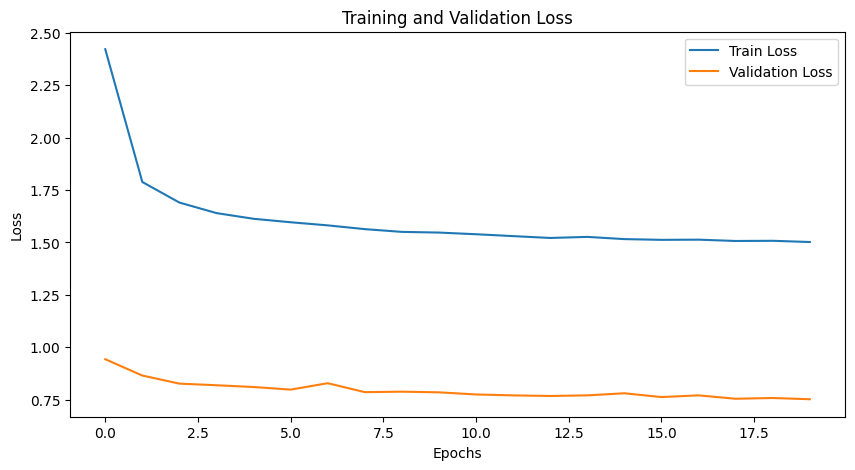

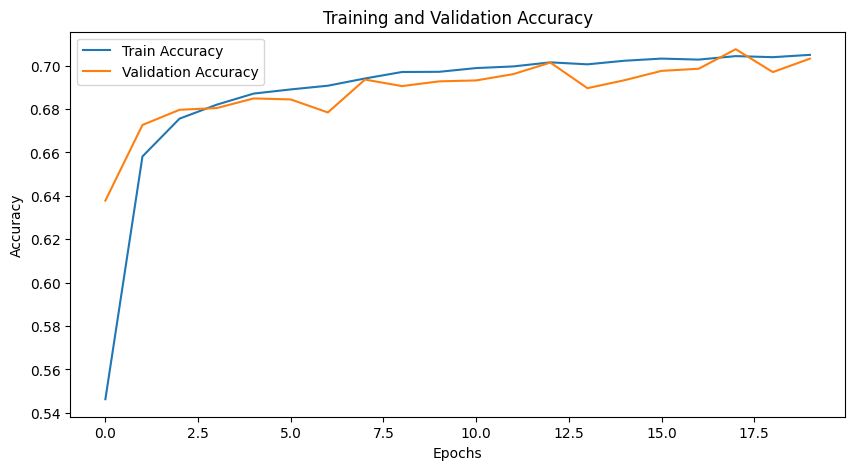

([2.421604439127641,
  1.7881802369336612,
  1.6900026473354122,
  1.6398502446588923,
  1.6126164576557815,
  1.596083530881366,
  1.5812750707884304,
  1.563297939105112,
  1.5502322245328153,
  1.54693674357211,
  1.5389441505807344,
  1.529997118916668,
  1.5212412610894344,
  1.5262770340090892,
  1.5157428794219845,
  1.5122184408981292,
  1.5131042306540443,
  1.506791500771632,
  1.5076543847556974,
  1.501844718563752],
 [0.9427413486066412,
  0.8648685593096936,
  0.8262404174101158,
  0.8185893111541623,
  0.8101028062281062,
  0.7977777812324587,
  0.8283229074517234,
  0.7856278023758873,
  0.7878732212254258,
  0.784768208128507,
  0.7745468772825648,
  0.7701659368686988,
  0.767310914446096,
  0.7702953488123222,
  0.7802192192585742,
  0.7621244534117276,
  0.7702926197012917,
  0.7541243907858114,
  0.7577497959136963,
  0.7518858890064427],
 [0.546298076923077,
  0.6581650641025641,
  0.6755809294871795,
  0.6819951923076923,
  0.6871274038461539,
  0.689046474358974

In [291]:
train_classifier(classifier,torch.nn.NLLLoss(),torch.optim.Adam,20,Noise_Low_era_train_loader,Noise_Low_era_test_loader,subset_size = 18,overlap = 6, lr = 0.01)

In [150]:
print(classifier)

EncoderClassifier(
  (encoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
    (5): ReLU()
  )
  (linear): Sequential(
    (0): Linear(in_features=10, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=12, bias=True)
  )
  (softmax): Softmax(dim=1)
)


# Calibration Curve

In [29]:
#CLasse chooser for calibration Curver
cls=7

49920


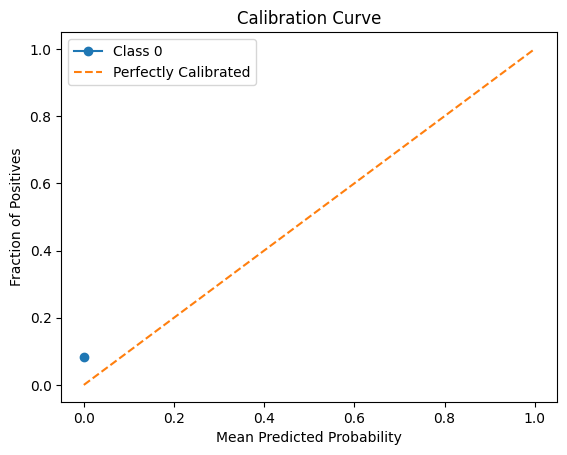

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import torch

def binarize(target, c):
    return np.array([1 if t == c else 0 for t in target])

Model=classifier

Model.eval()  # Set model to evaluation mode
y_true = []
y_probabilities = []

# Iterate over test_loader to get predictions and true labels
for inputs, labels in Noise_test_loader:
    inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)

    # Forward pass
    outputs = Model(inputs)
    probabilities = outputs
    y_true.extend(labels.cpu().numpy())  # Collect true labels
    y_probabilities.extend(probabilities[:, 0].detach().cpu().numpy())  # Collect probabilities for class 0

y_true_binarized = binarize(y_true, 0)
# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_true_binarized, y_probabilities, n_bins=10)
print(prob_)
# Plot calibration curve
plt.plot(prob_pred, prob_true, marker='o', label="Class")
plt.plot([0, 1], [0, 1], linestyle='--', label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()

In [33]:
print(len(y_true_binarized))

49920
